In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import os
import pickle
import copy
import time

from scipy.optimize import curve_fit, minimize, differential_evolution
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from matplotlib.patches import Wedge
from pprint import pprint


## Set experimental parameters

In [2]:


strainIDs = ["K253", "K168", "K037", "K241", "K209"]  # Species IDs
species_colors=['orange','blue', 'purple', 'green',  'black']

#strainID='K253'
#strainID='K168'
#strainID='K037'
#strainID='K241'
strainID='K209'

base_path = '/content/drive/MyDrive/SYNC_Projects/IS'

# Define parameters for each mutation-transposition level
num_mutationsSNP = 3  # Number of mutation levels
num_mutationsIS = 3  # Number of transposition levels
segregation_rate=1e-7

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
antibiotic_concentration = 0.0  # No antibiotic for this run
B0=1e8
od2cells = 1e9

Amax=0.4

## Connect to Google Drive

In [3]:

import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default

sheet_url = 'https://docs.google.com/spreadsheets/d/1iLrh-ODod5xqy33FcX-QvWA1QQPRHsqCHBk9kCEro2A/'


# Authenticate to access Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Load the Google Sheet by its URL
sheet = gc.open_by_url(sheet_url)

# Select the worksheet by name "Data"
worksheet = sheet.worksheet('Data')

# Convert worksheet to a Pandas DataFrame, removing empty rows and columns
df = get_as_dataframe(worksheet, evaluate_formulas=True, skiprows=0, header=0, dtype=str).dropna(how='all').dropna(axis=1, how='all')

# Display the first few rows to verify
print(df)


  Antibiotic Strain       ODmax StrainID IC90  SNP_rate  IS1_rate      ODmax1  \
0  Colistina   K209  1298166700     K209  0.1  1.52e-08  1.69e-09  1200000000   
1  Colistina   K209  1105500000    K209p  0.1  1.21e-08  5.18e-08  1200000000   
2  Colistina   K241  1242830000     K241  0.1  3.57e-09  1.25e-08  1200000000   
3  Colistina   K241  1348500000    K241p  0.1  5.29e-09  8.82e-09  1200000000   
4  Colistina   K037  1292000000     K037  0.1  1.12e-08         0  1200000000   
5  Colistina   K037  1270666670    K037p  0.1     8e-09   1.6e-09  1200000000   
6  Colistina   K168  1260500000     K168  0.1  1.73e-08         0  1200000000   
7  Colistina   K168  1275333000    K168p  0.1  5.19e-09  1.21e-08  1200000000   
8  Colistina   K253  1270000000     K253  0.1  1.25e-08  3.58e-09  1200000000   
9  Colistina   K253  1250000000    K253p  0.1  7.15e-09  8.94e-09  1200000000   

     IC901    ODmax1.1 IC901.1              SNP_rate1               IS1_rate1  \
0     0.11  1200000000     

## Simple Model

In [4]:
def gillespie_bacterial_growth_batch(strains, initial_resource, simulation_time, antibiotic_concentration, dt=0.1, num_simulations=3):
    """
    Simulates bacterial growth with multiple mutant levels, resource limitation, and antibiotic-induced death
    using a batch update approach. Runs multiple simulations and returns the mean population size.

    Parameters:
    - strains (list of dict): List of strain dictionaries with parameters:
        - 'initial_population' (float): Initial population size.
        - 'birth_rate' (float): Birth rate.
        - 'death_rate' (float): Base death rate.
        - 'K' (float): Half-saturation constant for resource consumption.
        - 'A_half' (float): Half-saturation constant for antibiotic concentration.
        - 'c' (float): Resource consumption rate per birth event.
    - initial_resource (float): Initial resource level.
    - simulation_time (float): Maximum simulation time.
    - antibiotic_concentration (float): Antibiotic concentration affecting death rate.
    - dt (float): Time step for batch updates.
    - num_simulations (int): Number of independent simulations to average.

    Returns:
    - t_values (list): Time points where changes occurred.
    - mean_population_values (list of lists): Mean population sizes of each strain at corresponding time points.
    - mean_R_values (list): Mean resource levels at corresponding time points.
    """

    all_t_values = []
    all_population_values = []
    all_R_values = []

    for sim in range(num_simulations):
        # Initialize time and populations
        t = 0
        populations = [strain['initial_population'] for strain in strains]
        R = initial_resource

        # Record initial conditions
        t_values = [t]
        population_values = [populations[:]]
        R_values = [R]

        while t < simulation_time:
            # Check for extinction or resource depletion
            if sum(populations) <= 0 or R <= 0:
                t += dt
                t_values.append(t)
                population_values.append(populations[:])
                R_values.append(R)
                continue

            # Calculate birth and death events for each strain
            births = [
                np.random.poisson(strain['birth_rate'] * populations[i] * (R / (R + strain['K'])) * dt)
                for i, strain in enumerate(strains)
            ]

            deaths = [
                np.random.poisson(strain['death_rate'] * populations[i] * (antibiotic_concentration /
                        (antibiotic_concentration + strain['A_half'])) * dt)
                for i, strain in enumerate(strains)
            ]

            # Update populations and resources after birth and death events
            for i in range(len(populations)):
                populations[i] += births[i] - deaths[i]

            # Decrease resource based on total births across strains
            total_resource_consumption = sum(births[i] * strains[i]['c'] for i in range(len(strains)))
            R -= total_resource_consumption

            # Ensure populations and resources are non-negative
            populations = [max(0, pop) for pop in populations]
            R = max(R, 0)

            # Advance time and record results
            t += dt
            t_values.append(t)
            population_values.append(populations[:])
            R_values.append(R)

        # Store results from this simulation
        all_t_values.append(t_values)
        all_population_values.append(population_values)
        all_R_values.append(R_values)

    # Convert lists to NumPy arrays for averaging
    all_t_values = np.array(all_t_values)
    all_population_values = np.array(all_population_values)
    all_R_values = np.array(all_R_values)

    # Compute mean results across simulations
    mean_t_values = np.mean(all_t_values, axis=0)
    mean_population_values = np.mean(all_population_values, axis=0)
    mean_R_values = np.mean(all_R_values, axis=0)

    return mean_t_values, mean_population_values, mean_R_values


In [5]:

def plotSimulation(time_points, population_values, resource):
    """
    Plots the results of the simulation for all strains and resource depletion using a blues colormap.
    The wild-type strain is plotted in black, and the colormap for mutants skips the first (white) color.

    Parameters:
    time_points (list): Time points from the simulation.
    population_values (list of list): Population sizes of each strain at corresponding time points.
    resource (list): Resource levels over time.
    """
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)

    # Get the number of strains (only one type of population without plasmid-free/plasmid-bearing distinction)
    num_strains = len(population_values[0])

    # Define a colormap (Blues)
    cmap = plt.get_cmap('Blues')

    # Plot populations: wild-type in black, mutants in shades of blue
    for i in range(num_strains):
        linestyle = '-' if i == 0 else '--'  # Wild-type solid, mutants dashed
        color = 'black' if i == 0 else cmap(i / num_strains)
        axes[0].plot(time_points, [(pop[i]) for pop in population_values], label=f'Strain {i}', color=color, linestyle=linestyle)

    axes[0].set_xlabel('Time (hours)', fontsize=14)
    axes[0].set_ylabel('Population', fontsize=14)
    axes[0].set_yscale('log')  # Apply log scale to the population plot
    axes[0].tick_params(axis='both', labelsize=12)

    # Plot resource depletion
    axes[1].plot(time_points, resource, color='orange', label='Resource')
    axes[1].set_xlabel('Time (hours)', fontsize=14)
    axes[1].set_ylabel('Resource concentration', fontsize=14)
    axes[1].tick_params(axis='both', labelsize=12)
    axes[1].set_ylim([0, 1.1])

    plt.show()


## Determination of Monod parameters

In [6]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define relative paths from the base path
pathPARAMS = os.path.join(base_path, 'data/')

# Verify paths and imported data
print("pathDATA:", pathPARAMS)

fileName="DO_kinetic_37_24h_new_plates_PR1_271124_Paloma_3.txt"
# Define the full file path
file_path = os.path.join(pathPARAMS, fileName)

# Verify the file path
print("Full file path:", file_path)

# Example metadata for strains
strain_metadata = {
    "A": ["K241", "", "K241", "", "K241", "", "K241", "", "K241", "", "K241", "", "K241"],
    "B": ["", "K241", "", "K241", "", "K241", "", "K241", "", "K241", "", "K241", ""],
    "C": ["K037", "", "K037", "", "K037", "", "K037", "", "K037", "", "K037", ""],
    "D": ["", "K037", "", "K037", "", "K037", "", "K037", "", "K037", "", "K037", ""],
    "E": ["K209", "", "K209", "", "K209", "", "K209", "", "K209", "", "K209", ""],
    "F": ["", "K209", "", "K209", "", "K209", "", "K209", "", "K209", "", "K209", ""],
    "G": ["K168", "", "K168", "", "K168", "", "K168", "", "K168", "", "K168", ""],
    "H": ["", "K168", "", "K168", "", "K168", "", "K168", "", "K168", "", "K168", ""],
    "I": ["", "", "", "", "", "K253", "", "K253", "", "K253", "", "K253", ""],
    "J": [ "K253", "", "", "", "", "", "", "", "", "", "", "", ""],
    "K": [ "", "", "", "K253", "", "K253", "", "K253", "", "K253", "", "K253", ""]
}

# Example metadata for plasmid condition
plasmid_metadata = {
    "A": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "B": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "C": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "D": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "E": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "F": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "G": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "H": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "I": [ "", "", "", "", "", "0", "", "0", "", "0", "", "0", ""],
    "J": [ "0", "", "", "", "", "", "", "", "", "", "", "", ""],
    "K": [ "", "", "", "p", "", "p", "", "p", "", "p", "", "p", ""]
}

# Convert to structured dictionary
plate_metadata = {}
for row in "ABCDEFGHIJK":
    for col in range(1, 13):
        well = f"{row}{col}"
        strain = strain_metadata[row][col-1]
        plasmid = plasmid_metadata[row][col-1]

        # Only store if there's valid data
        if strain:
            plate_metadata[well] = {
                "strain": strain,
                "plasmid_condition": plasmid
            }

for well in ["A1", "B2", "C3", "D4", "E5", "F6", "I10",  "I12", "I6", "I8", "J1", "K10", "K12", "K4", "K6", "K8"]:
    if well in plate_metadata:
        print(f"{well}: {plate_metadata[well]}")
    else:
        print(f"{well}: Empty")

Mounted at /content/drive
pathDATA: /content/drive/MyDrive/SYNC_Projects/IS/data/
Full file path: /content/drive/MyDrive/SYNC_Projects/IS/data/DO_kinetic_37_24h_new_plates_PR1_271124_Paloma_3.txt
A1: {'strain': 'K241', 'plasmid_condition': 'p'}
B2: {'strain': 'K241', 'plasmid_condition': '0'}
C3: {'strain': 'K037', 'plasmid_condition': 'p'}
D4: {'strain': 'K037', 'plasmid_condition': '0'}
E5: {'strain': 'K209', 'plasmid_condition': 'p'}
F6: {'strain': 'K209', 'plasmid_condition': '0'}
I10: {'strain': 'K253', 'plasmid_condition': '0'}
I12: {'strain': 'K253', 'plasmid_condition': '0'}
I6: {'strain': 'K253', 'plasmid_condition': '0'}
I8: {'strain': 'K253', 'plasmid_condition': '0'}
J1: {'strain': 'K253', 'plasmid_condition': '0'}
K10: {'strain': 'K253', 'plasmid_condition': 'p'}
K12: {'strain': 'K253', 'plasmid_condition': 'p'}
K4: {'strain': 'K253', 'plasmid_condition': 'p'}
K6: {'strain': 'K253', 'plasmid_condition': 'p'}
K8: {'strain': 'K253', 'plasmid_condition': 'p'}


In [7]:
def get_wells_by_strain_condition(plate_metadata, strain, condition):
    """
    Returns a list of wells that match a specific strain and plasmid condition.

    Parameters:
    plate_metadata (dict): Dictionary containing well metadata.
    strain (str): The strain name to filter (e.g., "K241").
    condition (str): The plasmid condition to filter (e.g., "p" or "0").

    Returns:
    list: Wells that match the specified strain and plasmid condition.
    """
    matching_wells = [
        well for well, data in plate_metadata.items()
        if data["strain"] == strain and data["plasmid_condition"] == condition
    ]
    return matching_wells



In [8]:
# Read the file with proper delimiter handling
df_od = pd.read_csv(file_path, delimiter=r"\s+", decimal=",", engine='python')

# Rename first column for clarity
df_od.rename(columns={df_od.columns[0]: "Well"}, inplace=True)

# Extract time points (convert to float hours)
time_labels = df_od.columns[1:]
time_hours = np.array([int(t.split(":")[0]) + int(t.split(":")[1]) / 60 for t in time_labels], dtype=float)

# Convert OD values to numeric format
od_values = df_od.iloc[:, 1:].replace(',', '.', regex=True).astype(float).to_numpy()

# Extract well labels
well_labels = df_od["Well"].to_numpy()



# Print shapes to confirm correctness
print(f"Time (hours) shape: {time_hours.shape}")
print(f"OD Values shape: {od_values.shape}")


Time (hours) shape: (145,)
OD Values shape: (106, 145)


In [9]:


def get_od_data_by_strain_condition(plate_metadata, od_values, well_labels, time_hours, strain, condition):
    """
    Retrieves OD values for wells corresponding to a specific strain and plasmid condition.
    Computes mean and standard deviation across the replicates.

    Parameters:
    plate_metadata (dict): Dictionary containing well metadata.
    od_values (numpy array): 2D array of OD values (wells × time points).
    well_labels (numpy array): List of well identifiers corresponding to rows in od_values.
    time_hours (numpy array): Array of time points in hours.
    strain (str): The strain name to filter (e.g., "K241").
    condition (str): The plasmid condition to filter (e.g., "p" or "0").

    Returns:
    tuple: (mean_od, std_od, time_hours) - mean and standard deviation OD over time.
    """
    # Get wells matching the strain and condition
    wells = get_wells_by_strain_condition(plate_metadata, strain, condition)

    # Find indices of matching wells
    well_indices = [np.where(well_labels == well)[0][0] for well in wells if well in well_labels]

    # Extract OD values for the selected wells
    if not well_indices:
        print(f"No matching wells found for strain {strain} with condition {condition}")
        return None, None, time_hours

    selected_od_values = od_values[well_indices, :]  # Extract only matching wells

    # Compute mean and standard deviation
    mean_od = np.mean(selected_od_values, axis=0)
    std_od = np.std(selected_od_values, axis=0)

    return mean_od, std_od, time_hours

def convert_od_to_cell_density(mean_od, std_od, od2cells=1e9):
    """
    Converts OD values to cell densities.

    Parameters:
    mean_od (numpy array): Mean OD over time.
    std_od (numpy array): Standard deviation of OD over time.
    od2cells (float): Conversion factor from OD to cell density (default: 1e9 cells per OD unit).

    Returns:
    mean_cell_densities (numpy array): Mean cell density over time.
    std_cell_densities (numpy array): Standard deviation of cell density over time.
    """
    mean_cell_densities = mean_od * od2cells
    std_cell_densities = std_od * od2cells
    return mean_cell_densities, std_cell_densities



In [10]:


def objective_time_series(params, time_hours, od_experimental, initial_resource, simulation_time, strains_guess):
    """
    Objective function for fitting birth rate, consumption rate, and half-saturation resource
    to the full OD time series.

    Parameters:
    - params: (birth_rate, half_saturation_resource, consumption_rate)
    - time_hours: Experimental time points (in hours)
    - od_experimental: Experimental OD values
    - initial_resource: Initial resource concentration
    - simulation_time: Total simulation time
    - strains_guess: Initial strain parameters

    Returns:
    - Error (sum of squared residuals)
    """
    birth_rate, half_saturation_resource, consumption_rate = params

    # Create a copy of the strain parameters (to avoid modifying the original list)
    strains = copy.deepcopy(strains_guess)

    # Update parameters
    strains[0]['birth_rate'] = birth_rate
    strains[0]['c'] = consumption_rate
    strains[0]['K'] = half_saturation_resource

    # Run the simulation
    sim_time, population_values, _ = gillespie_bacterial_growth_batch(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentration=0.0  # No antibiotic in optimization
    )

    # Convert simulated cell density to OD (assuming 1e9 cells = 1 OD)
    od_simulated = np.array([pop[0]  for pop in population_values])

    # Interpolate simulation results to match experimental time points
    od_simulated_interp = np.interp(time_hours, sim_time, od_simulated)

    # Compute error (sum of squared residuals)
    error = np.sum((od_simulated_interp - od_experimental) ** 2)

    return error


In [11]:
condition = "p"

# Retrieve data
mean_od_p, std_od_p, time_hours_p = get_od_data_by_strain_condition(plate_metadata, od_values, well_labels, time_hours, strainID, condition)

# Convert OD to cell densities
mean_cell_densities_p, std_cell_densities_p = convert_od_to_cell_density(mean_od_p, std_od_p)

# Initial guesses
birth_rate_guess_p = 1.0
consumption_rate_guess_p = 5e-9
half_saturation_resource_guess_p = 0.5
initial_guess_p = [birth_rate_guess_p, half_saturation_resource_guess_p, consumption_rate_guess_p]


# Use the optimized parameters for plasmid-bearing strains
strains_guess_p = [
    {
        'birth_rate': birth_rate_guess_p,
        'death_rate': 0.0,  # tmp
        'initial_population': B0,
        'K': half_saturation_resource_guess_p,
        'c': consumption_rate_guess_p,
        'A_half': 0.1  #
    }
]

# Define parameter bounds
bounds_p = [(0.8, 1.4), (0.4, 0.6), (1e-10, 20e-8)]

# Run optimization
result_p = differential_evolution(
    objective_time_series, bounds_p,
    args=(time_hours_p, mean_cell_densities_p, initial_resource, simulation_time, strains_guess_p),
    popsize=50, maxiter=1000, tol=1e-3
)

# Extract optimized parameters
optimized_birth_rate_p, optimized_half_saturation_resource_p, optimized_consumption_rate_p = result_p.x

# Print optimized results
print("\nOptimization Results (Plasmid-Bearing):")
print(f"Optimized birth_rate_p: {optimized_birth_rate_p:.3f}")
print(f"Optimized consumption_rate_p: {optimized_consumption_rate_p:.3e}")
print(f"Optimized half_saturation_resource_p: {optimized_half_saturation_resource_p:.3e}")
print(f"Final Objective Value (Error from Target): {result_p.fun:.2e}")

# Run simulation with optimized parameters
optimized_strains_p = copy.deepcopy(strains_guess_p)
optimized_strains_p[0]['birth_rate'] = optimized_birth_rate_p
optimized_strains_p[0]['c'] = optimized_consumption_rate_p
optimized_strains_p[0]['K'] = optimized_half_saturation_resource_p

sim_time_p, final_population_values_p, _ = gillespie_bacterial_growth_batch(
    strains=optimized_strains_p,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentration=0.0
)

# Convert simulated population to cell densities
optimized_cell_densities_p = np.array([pop[0] for pop in final_population_values_p])


# Use the optimized parameters for strains_0
strains_p = [
    {
        'birth_rate': optimized_birth_rate_p,
        'death_rate': 0.1,  # Keeping the original death rate unless specified otherwise
        'initial_population': B0,
        'K': optimized_half_saturation_resource_p,
        'c': optimized_consumption_rate_p,
        'A_half': 0.5  # Keeping this parameter unchanged as it's not optimized here
    }
]


Optimization Results (Plasmid-Bearing):
Optimized birth_rate_p: 0.800
Optimized consumption_rate_p: 1.094e-09
Optimized half_saturation_resource_p: 6.000e-01
Final Objective Value (Error from Target): 8.85e+17


In [12]:
condition = "0"

# Retrieve data
mean_od_0, std_od_0, time_hours_0 = get_od_data_by_strain_condition(plate_metadata, od_values, well_labels, time_hours, strainID, condition)

# Convert OD to cell densities
mean_cell_densities_0, std_cell_densities_0 = convert_od_to_cell_density(mean_od_0, std_od_0)

# Initial guesses
birth_rate_guess_0 = 1.0
consumption_rate_guess_0 = 5e-9
half_saturation_resource_guess_0 = 0.5
initial_guess_0 = [birth_rate_guess_0, half_saturation_resource_guess_0, consumption_rate_guess_0]


# Use the optimized parameters for plasmid-free strains
strains_guess_0 = [
    {
        'birth_rate': birth_rate_guess_0,
        'death_rate': 0.0,  # tmp
        'initial_population': B0,
        'K': half_saturation_resource_guess_0,
        'c': consumption_rate_guess_0,
        'A_half': 0.1  #
    }
]

# Define parameter bounds
bounds_0 = [(0.8, 1.4), (0.4, 0.6), (1e-10, 20e-8)]

# Run optimization
result_0 = differential_evolution(
    objective_time_series, bounds_0,
    args=(time_hours_0, mean_cell_densities_0, initial_resource, simulation_time, strains_guess_0),
    popsize=50, maxiter=1000, tol=1e-3
)

# Extract optimized parameters
optimized_birth_rate_0, optimized_half_saturation_resource_0, optimized_consumption_rate_0 = result_0.x

# Print optimized results
print("\nOptimization Results (Plasmid-Free):")
print(f"Optimized birth_rate_0: {optimized_birth_rate_0:.3f}")
print(f"Optimized consumption_rate_0: {optimized_consumption_rate_0:.3e}")
print(f"Optimized half_saturation_resource_0: {optimized_half_saturation_resource_0:.3e}")
print(f"Final Objective Value (Error from Target): {result_0.fun:.2e}")

# Run simulation with optimized parameters
optimized_strains_0 = copy.deepcopy(strains_guess_0)
optimized_strains_0[0]['birth_rate'] = optimized_birth_rate_0
optimized_strains_0[0]['c'] = optimized_consumption_rate_0
optimized_strains_0[0]['K'] = optimized_half_saturation_resource_0

sim_time_0, final_population_values_0, _ = gillespie_bacterial_growth_batch(
    strains=optimized_strains_0,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentration=0.0
)

# Convert simulated population to cell densities
optimized_cell_densities_0 = np.array([pop[0] for pop in final_population_values_0])


# Use the optimized parameters for strains_0
strains_0 = [
    {
        'birth_rate': optimized_birth_rate_0,
        'death_rate': 0.1,  # Keeping the original death rate unless specified otherwise
        'initial_population': B0,
        'K': optimized_half_saturation_resource_0,
        'c': optimized_consumption_rate_0,
        'A_half': 0.1  # Keeping this parameter unchanged as it's not optimized here
    }
]


Optimization Results (Plasmid-Free):
Optimized birth_rate_0: 0.820
Optimized consumption_rate_0: 8.648e-10
Optimized half_saturation_resource_0: 6.000e-01
Final Objective Value (Error from Target): 6.55e+17


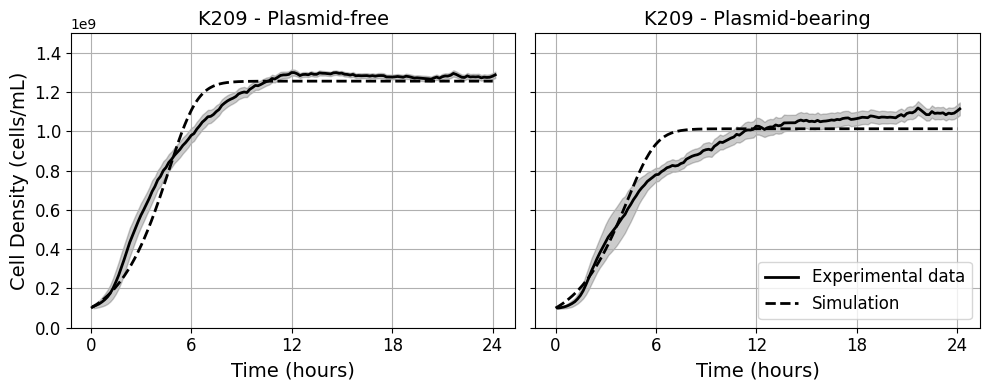

In [13]:

def plot_mean_std_cell_density(time_hours_0, mean_cell_densities_0, std_cell_densities_0,
                                            sim_time_0, optimized_cell_densities_0,
                                            time_hours_p, mean_cell_densities_p, std_cell_densities_p,
                                            sim_time_p, optimized_cell_densities_p,
                                            strainID, strainIDs, species_colors, ymax=1.5e9):
    """
    Plots the mean cell density over time with a shaded region representing standard deviation
    for both plasmid-free and plasmid-bearing conditions, using side-by-side subplots.

    Parameters:
    - time_hours_0, mean_cell_densities_0, std_cell_densities_0: Experimental data for plasmid-free
    - sim_time_0, optimized_cell_densities_0: Simulated data for plasmid-free
    - time_hours_p, mean_cell_densities_p, std_cell_densities_p: Experimental data for plasmid-bearing
    - sim_time_p, optimized_cell_densities_p: Simulated data for plasmid-bearing
    - strainID (str): Strain identifier.
    - strainIDs (list): List of strain IDs.
    - species_colors (list): List of colors corresponding to strains.
    """

    # Assign color based on strainID
    strain_index = strainIDs.index(strainID)
    strain_color = species_colors[strain_index]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  # Side-by-side plots with shared y-axis

    # --- Plasmid-free condition (Left Subplot) ---
    ax0 = axes[0]
    ax0.plot(time_hours_0, mean_cell_densities_0, '-',  color=strain_color, lw=2)
    ax0.fill_between(time_hours_0,
                     mean_cell_densities_0 - std_cell_densities_0,
                     mean_cell_densities_0 + std_cell_densities_0,
                     color=strain_color, alpha=0.2)
    ax0.plot(sim_time_0, optimized_cell_densities_0, '--',  color=strain_color, lw=2)

    ax0.set_xlabel("Time (hours)", fontsize=14)
    ax0.set_ylabel("Cell Density (cells/mL)", fontsize=14)
    ax0.set_title(f"{strainID} - Plasmid-free", fontsize=14)
    ax0.grid(True)

    # Apply x/y ticks **to this axis**
    ax0.set_xticks([0, 6, 12, 18, 24])
    ax0.set_yticks(ax0.get_yticks())  # Maintain auto y-ticks
    ax0.tick_params(axis='both', labelsize=12)
    ax0.set_ylim([0, ymax])

    # --- Plasmid-bearing condition (Right Subplot) ---
    ax1 = axes[1]
    ax1.plot(time_hours_p, mean_cell_densities_p, '-', label="Experimental data", color=strain_color, lw=2)
    ax1.fill_between(time_hours_p,
                     mean_cell_densities_p - std_cell_densities_p,
                     mean_cell_densities_p + std_cell_densities_p,
                     color=strain_color, alpha=0.2)
    ax1.plot(sim_time_p, optimized_cell_densities_p, '--', label="Simulation", color=strain_color, lw=2)

    ax1.set_xlabel("Time (hours)", fontsize=14)
    ax1.set_title(f"{strainID} - Plasmid-bearing", fontsize=14)
    ax1.grid(True)
    ax1.legend(fontsize=12, loc="lower right")

    # Apply x/y ticks **to this axis**
    ax1.set_xticks([0, 6, 12, 18, 24])
    ax1.set_yticks(ax1.get_yticks())  # Maintain auto y-ticks
    ax1.tick_params(axis='both', labelsize=12)
    ax1.set_ylim([0, ymax])

    plt.tight_layout()
    plt.show()


plot_mean_std_cell_density(
    time_hours_0, mean_cell_densities_0, std_cell_densities_0,
    sim_time_0, optimized_cell_densities_0,
    time_hours_p, mean_cell_densities_p, std_cell_densities_p,
    sim_time_p, optimized_cell_densities_p,
    strainID, strainIDs, species_colors
)


In [14]:
def create_birth_rates(Nmuts, Nins, max_birth_rate, min_birth_rate):
    """
    Creates a birth_rates matrix where birth rates progressively decrease from
    the top-left (0,0) corner toward the bottom-right (Nmuts-1, Nins-1) corner.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    max_birth_rate (float): The birth rate at position (0,0) (highest birth rate).
    min_birth_rate (float): The birth rate at position (Nmuts-1, Nins-1) (lowest birth rate).

    Returns:
    np.array: A 2D array representing birth_rates with a gradient of decreasing birth rates.
    """
    # Initialize the birth_rates matrix
    birth_rates = np.zeros((Nmuts, Nins))

    # Calculate step size for the decrease in birth rate across the matrix
    for i in range(Nmuts):
        for j in range(Nins):
            # Calculate linear interpolation based on position
            rate = max_birth_rate - (max_birth_rate - min_birth_rate) * (i + j) / (Nmuts + Nins - 2)
            birth_rates[i, j] = rate

    return birth_rates

# Example usage
max_birth_rate_0 = optimized_birth_rate_0  # Birth rate for mutation level 0 (wild-type)
min_birth_rate_0 = optimized_birth_rate_0*0.95  # Birth rate for the highest mutation level (most resistant)

# Create the birth_rates matrix
birth_rates_0 = create_birth_rates(num_mutationsSNP, num_mutationsIS, max_birth_rate_0, min_birth_rate_0)

# Print birth_rates for verification
print("Birth Rates_0:\n", birth_rates_0)

max_birth_rate_p = optimized_birth_rate_p  # Birth rate for mutation level 0 (wild-type)
min_birth_rate_p = optimized_birth_rate_p*0.95  # Birth rate for the highest mutation level (most resistant)

# Create the birth_rates matrix
birth_rates_p = create_birth_rates(num_mutationsSNP, num_mutationsIS, max_birth_rate_p, min_birth_rate_p)

# Print birth_rates for verification
print("Birth Rates_p:\n", birth_rates_p)


Birth Rates_0:
 [[0.81988692 0.80963834 0.79938975]
 [0.80963834 0.79938975 0.78914117]
 [0.79938975 0.78914117 0.77889258]]
Birth Rates_p:
 [[0.80002204 0.79002176 0.78002149]
 [0.79002176 0.78002149 0.77002121]
 [0.78002149 0.77002121 0.76002094]]


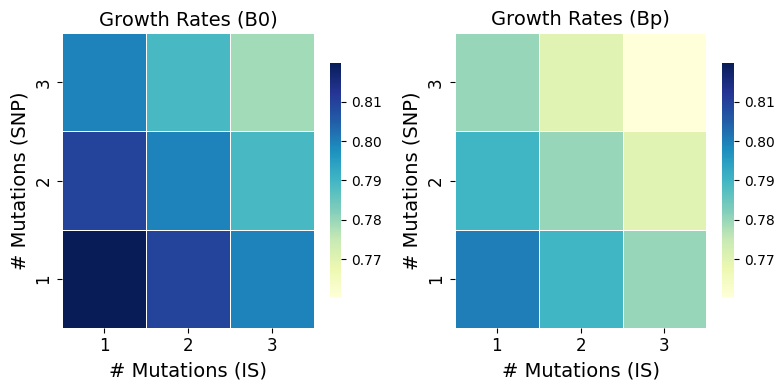

In [15]:


def plotBirthRateMatrices(birth_rates_0, birth_rates_p, Nmuts, Nins):
    """
    Plots the birth rate matrices for plasmid-free and plasmid-bearing strains using the same color scale.

    Parameters:
    birth_rates_0 (np.array): 2D array of birth rates for plasmid-free strains.
    birth_rates_p (np.array): 2D array of birth rates for plasmid-bearing strains.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    """
    # Determine the global color scale across both matrices
    vmin = min(birth_rates_0.min(), birth_rates_p.min())
    vmax = max(birth_rates_0.max(), birth_rates_p.max())

    # Set up the matplotlib figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot birth rate matrix for plasmid-free strains
    sns.heatmap(birth_rates_0[::-1], ax=axes[0], cmap='YlGnBu', vmin=vmin, vmax=vmax, annot=False,
                cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white')
    axes[0].set_title("Growth Rates (B0)", fontsize=14)
    axes[0].set_xlabel('# Mutations (IS)', fontsize=14)
    axes[0].set_ylabel('# Mutations (SNP)', fontsize=14)
    axes[0].set_yticks(np.arange(Nmuts) + 0.5)
    axes[0].set_yticklabels(np.arange(1, Nmuts + 1)[::-1], fontsize=12)
    axes[0].set_xticks(np.arange(Nins) + 0.5)
    axes[0].set_xticklabels(np.arange(1, Nins + 1), fontsize=12)

    # Plot birth rate matrix for plasmid-bearing strains
    sns.heatmap(birth_rates_p[::-1], ax=axes[1], cmap='YlGnBu', vmin=vmin, vmax=vmax, annot=False,
                cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white')
    axes[1].set_title("Growth Rates (Bp)", fontsize=14)
    axes[1].set_xlabel('# Mutations (IS)', fontsize=14)
    axes[1].set_ylabel('# Mutations (SNP)', fontsize=14)
    axes[1].set_yticks(np.arange(Nmuts) + 0.5)
    axes[1].set_yticklabels(np.arange(1, Nmuts + 1)[::-1], fontsize=12)
    axes[1].set_xticks(np.arange(Nins) + 0.5)
    axes[1].set_xticklabels(np.arange(1, Nins + 1), fontsize=12)

    plt.tight_layout()
    plt.show()

plotBirthRateMatrices(birth_rates_0, birth_rates_p, Nmuts=num_mutationsSNP, Nins=num_mutationsIS)


In [16]:


def create_consumption_rates(Nmuts, Nins, consumption_rate):
    """
    Creates a consumption_rates matrix with a linear relationship between the number of mutations (y-axis) and consumption rate.
    As the number of mutations increases, the consumption rate decreases.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    max_consumption_rate (float): The consumption rate at mutation level 0 (highest consumption rate).
    min_consumption_rate (float): The consumption rate at the highest mutation level (lowest consumption rate).

    Returns:
    np.array: A 2D array representing consumption_rates.
    """
    # Create a linear decrease in consumption rates from max_consumption_rate to min_consumption_rate across mutation levels
    #mutation_levels = np.linspace(max_consumption_rate, min_consumption_rate, Nmuts)

    # Create the consumption_rates matrix by repeating the mutation-level consumption rates across all insertions (columns)
    #consumption_rates = np.tile(mutation_levels[:, np.newaxis], (1, Nins))


    # Create the consumption_rates matrix filled with the same rate across all entries
    consumption_rates = np.full((Nmuts, Nins), consumption_rate)

    return consumption_rates

# Create the consumption_rates matrix
consumption_rates_0 = create_consumption_rates(num_mutationsSNP, num_mutationsIS, optimized_consumption_rate_0)


# Create the consumption_rates matrix for plasmid-bearing
consumption_rates_p = create_consumption_rates(num_mutationsSNP, num_mutationsIS, optimized_consumption_rate_p)


In [17]:


def create_half_saturation_resource(Nmuts, Nins, half_saturation_resource):
    """
    Creates a flat half_saturation_resource matrix where the half-saturation resource value is the same across
    all mutation and insertion levels.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    half_saturation_resource (float): The constant half-saturation resource value for all levels.

    Returns:
    np.array: A 2D array representing flat half_saturation_resource values.
    """
    # Create the half_saturation_resource matrix filled with the same value across all entries
    half_saturation_matrix = np.full((Nmuts, Nins), half_saturation_resource)

    return half_saturation_matrix

# Example usage
half_saturation_resource_0 = optimized_half_saturation_resource_0  # Constant half-saturation for plasmid-free strains
half_saturation_resource_p = optimized_half_saturation_resource_p  # Constant half-saturation for plasmid-bearing strains

# Create the half_saturation_resource matrices
half_saturation_resource_rates_0 = create_half_saturation_resource(num_mutationsSNP, num_mutationsIS, half_saturation_resource_0)
half_saturation_resource_rates_p = create_half_saturation_resource(num_mutationsSNP, num_mutationsIS, half_saturation_resource_p)


## Parameterize drug resistance levels

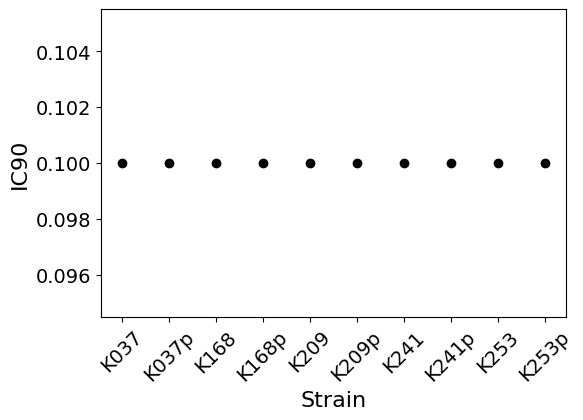

In [18]:

# Ensure the IC90 column is numeric
df['IC90'] = pd.to_numeric(df['IC90'], errors='coerce')  # Convert and handle errors as NaN

# Drop rows with NaN values in IC90 if any
df = df.dropna(subset=['IC90'])

# Calculate the mean and standard deviation of IC90 for each modified strain
grouped = df.groupby('StrainID')['IC90'].agg(['mean', 'std']).reset_index()

# Create error bar plot
plt.figure(figsize=(6, 4))
plt.errorbar(grouped['StrainID'], grouped['mean'], yerr=grouped['std'], fmt='o', capsize=5, capthick=2, elinewidth=1.5, color='black')

plt.xlabel("Strain", fontsize=16)
plt.ylabel("IC90", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.show()


In [19]:
def get_mean_IC90(strain_id):
    """
    Returns the mean IC90 for a specified strain ID.

    Parameters:
    strain_id (str): The strain ID to look up.

    Returns:
    float: Mean IC90 value for the specified strain ID, or None if the strain is not found.
    """
    # Filter the grouped DataFrame for the specified strain ID
    result = grouped[grouped['StrainID'] == strain_id]

    # Check if strain exists and return the mean IC90, else None
    if not result.empty:
        mean_ic90 = result['mean'].values[0]
        print(f"The mean IC90 for strain {strain_id} is: {mean_ic90}")
        return mean_ic90
    else:
        print(f"Strain {strain_id} not found in the data.")
        return None


strainID_p="%sp" % strainID
mean_ic90_0 = get_mean_IC90(strainID)
mean_ic90_p = get_mean_IC90(strainID_p)


The mean IC90 for strain K209 is: 0.1
The mean IC90 for strain K209p is: 0.1


In [20]:


def run_dose_response(strains, initial_resource, simulation_time, antibiotic_concentrations, toPlot=False):
    """
    Runs the gillespie_bacterial_growth_batch simulation over a range of antibiotic concentrations
    and returns the final population density (OD) for each concentration. Optionally plots OD vs. time
    for each concentration.

    Parameters:
    strains (list of dict): Strain parameters for the model.
    initial_resource (float): Initial resource concentration.
    simulation_time (float): Duration of the simulation.
    antibiotic_concentrations (list or np.array): Array of antibiotic concentrations to simulate.
    toPlot (bool): Whether to plot OD vs. time for each concentration.

    Returns:
    dict: A dictionary with antibiotic concentrations as keys and final OD values as values.
    """
    final_ODs = {}  # Dictionary to store final OD for each antibiotic concentration

    # Set up the color map and normalization for colorbar if plotting
    if toPlot:
        norm = mcolors.Normalize(vmin=min(antibiotic_concentrations), vmax=max(antibiotic_concentrations))
        cmap = cm.Reds
        plt.figure(figsize=(6, 4))  # Create a figure for plotting

    for i, antibiotic_concentration in enumerate(antibiotic_concentrations):
        # Run the simulation for the current antibiotic concentration
        t_values, population_values, R_values = gillespie_bacterial_growth_batch(
            strains, initial_resource, simulation_time, antibiotic_concentration
        )

        # Calculate the OD over time (sum of all populations at each time point)
        OD_values = [np.sum(pop) for pop in population_values]

        # Plot OD vs. time with a specific color based on antibiotic concentration
        if toPlot:
            if antibiotic_concentration == 0:
                color = 'black'  # Use black color for zero concentration
            else:
                color = cmap(norm(antibiotic_concentration))
            plt.plot(t_values, OD_values, color=color)

        # Calculate final OD as the total population at the last time point
        final_population = OD_values[-1]  # Final OD for this concentration
        final_ODs[antibiotic_concentration] = final_population

    # Configure and show plot if plotting is enabled
    if toPlot:
        # Set plot labels
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        #plt.yscale('log')  # Use log scale for OD if necessary

        # Create a colorbar for antibiotic concentration
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Only needed for ScalarMappable without data
        cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
        cbar.set_label('Antibiotic Concentration (μg/mL)', fontsize=12)

        plt.tight_layout()
        plt.show()

    return final_ODs

def computeIC(dose_response_results, IC, B0):
    """
    Computes the inhibitory concentration (IC) at which the desired percentage of inhibition is achieved,
    adjusting for the provided initial density B0.

    Parameters:
    dose_response_results (dict): Dictionary with antibiotic concentrations as keys and final OD values as values.
    IC (float): Percentage of inhibition to estimate (e.g., 50 for IC50, 90 for IC90).
    B0 (float): Initial OD (or density) at the start of the experiment.

    Returns:
    float: Interpolated antibiotic concentration for the specified inhibition percentage.
           Returns -1 if the desired inhibition is not achieved within the concentration range.
    """
    # Sort the dose-response results by concentration
    concentrations = np.array(sorted(dose_response_results.keys()))
    final_ODs = np.array([dose_response_results[conc] for conc in concentrations])

    # Subtract the initial density B0 from final ODs to calculate net growth
    net_growth_ODs = final_ODs - B0

    # Ensure that net growth values do not go below zero
    net_growth_ODs = np.maximum(net_growth_ODs, 0)

    # Calculate the target OD for the given inhibition percentage
    max_net_OD = net_growth_ODs[0]  # Assuming the first concentration has no drug
    target_OD = (1 - IC / 100) * max_net_OD

    # Check if the target OD is achieved within the given concentration range
    if np.all(net_growth_ODs > target_OD):
        #print("Target OD not achieved within the tested concentrations.")
        return -1  # Target inhibition not achieved

    # Find the concentrations surrounding the target OD for interpolation
    below_target = net_growth_ODs > target_OD
    idx_above = np.argmax(~below_target)  # First index where OD <= target_OD
    idx_below = idx_above - 1

    # Ensure there is a valid range for interpolation
    if idx_below < 0 or idx_above >= len(concentrations):
        #print("Interpolation failed: no valid points surrounding the target OD.")
        return -1

    # Linear interpolation to estimate IC value
    conc_below, conc_above = concentrations[idx_below], concentrations[idx_above]
    OD_below, OD_above = net_growth_ODs[idx_below], net_growth_ODs[idx_above]

    IC_concentration = conc_below + (target_OD - OD_below) * (conc_above - conc_below) / (OD_above - OD_below)
    return IC_concentration

def plot_dose_response(dose_response_results, IC_concentration=None, IC_label="IC"):
    """
    Plots the dose-response curve, showing the relationship between antibiotic concentration and final OD.
    Optionally annotates the plot with a vertical line at a specified IC value.

    Parameters:
    dose_response_results (dict): Dictionary with antibiotic concentrations as keys and final OD values as values.
    IC_concentration (float): Antibiotic concentration at the specified IC (e.g., IC50, IC90) to annotate on the plot.
                              If None, no annotation is added.
    IC_label (str): Label for the IC line, e.g., "IC50" or "IC90".
    """
    # Extract concentrations and final OD values, sorting by concentration
    concentrations = sorted(dose_response_results.keys())
    final_ODs = [dose_response_results[conc] for conc in concentrations]

    # Plot the dose-response curve
    plt.figure(figsize=(6,4))
    plt.plot(concentrations, final_ODs, marker='o', linestyle='-', color='black', label='Final OD')
    plt.xlabel('Antibiotic Concentration', fontsize=14)
    plt.ylabel('Final OD', fontsize=14)
    plt.grid(False)
    plt.ylim([0, np.max(final_ODs) * 1.1])

    # Annotate the IC concentration if provided
    if IC_concentration is not None:
        plt.axvline(IC_concentration, color='red', linestyle='--', label=f'{IC_label} = {IC_concentration:.3f}')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:


def objective(params, target_IC90, strains, initial_resource, simulation_time, antibiotic_concentrations):
    """
    Objective function to minimize the difference between the simulated IC90 and the target IC90.

    Parameters:
    - params: Tuple containing (death_rate, A_half).
    - target_IC90: Target IC90 value to approximate.
    - strains: Strain parameters template for the simulation.
    - initial_resource: Initial resource level for the simulation.
    - simulation_time: Duration of the simulation.
    - antibiotic_concentrations: Range of antibiotic concentrations for dose-response.

    Returns:
    - float: Absolute difference between simulated IC90 and target_IC90.
    """
    death_rate, A_half = params

    # Update strain parameters
    strains[0]['death_rate'] = death_rate
    strains[0]['A_half'] = A_half

    # Run the dose-response simulation with updated parameters
    final_ODs = run_dose_response(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentrations=antibiotic_concentrations
    )

    # Compute the IC90 with the current parameters
    simulated_IC90 = computeIC(final_ODs, IC=90, B0=B0)

    # Return a large value if IC90 is not achievable within the tested range
    if simulated_IC90 == -1:
        return float('inf')  # Penalize if IC90 is not achievable

    # Calculate and return the difference from the target IC90
    return abs(simulated_IC90 - target_IC90)



In [22]:

target_IC90_p = get_mean_IC90(strainID+'p')
print("Target IC90_p:", target_IC90_p)

# Range of concentrations
antibiotic_concentration_range = np.linspace(0, Amax, 50)

# Define bounds for each parameter (modify as necessary)
bounds = [(0.0001, 20), (0.0001, 20)]

# Objective function
result_p = differential_evolution(
    objective,
    bounds=bounds,
    args=(target_IC90_p, strains_p, initial_resource, simulation_time, antibiotic_concentration_range),
    tol=1e3,  # Can adjust as necessary
    strategy='best1bin',
    popsize=20
)

# Extract optimized parameters
optimized_death_rate_p, optimized_A_half_p = result_p.x

optimized_death_rate_p=5
optimized_A_half_p=10

print("Optimized death_rate_p:", optimized_death_rate_p)
print("Optimized A_half_p:", optimized_A_half_p)

# Compute IC90 with optimized parameters
strains_p[0]['death_rate'] = optimized_death_rate_p
strains_p[0]['A_half'] = optimized_A_half_p
dose_response_results_p = run_dose_response(
    strains=strains_p,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentrations=antibiotic_concentration_range,
    toPlot=False
)
computed_IC90_p = computeIC(dose_response_results_p, IC=90, B0=B0)
print("Computed IC90_p with optimized parameters:", computed_IC90_p)


The mean IC90 for strain K209p is: 0.1
Target IC90_p: 0.1


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Optimized death_rate_p: 5
Optimized A_half_p: 10
Computed IC90_p with optimized parameters: 0.16932819623918205


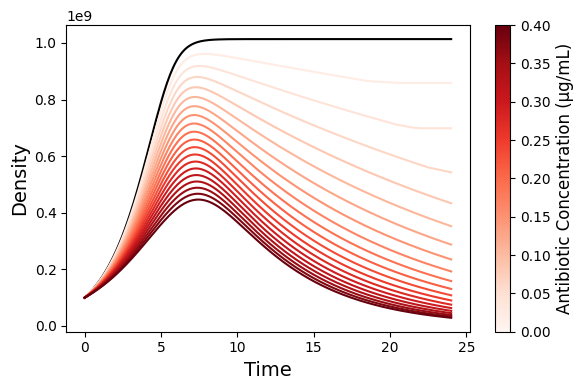

IC90: 0.16934908045160893


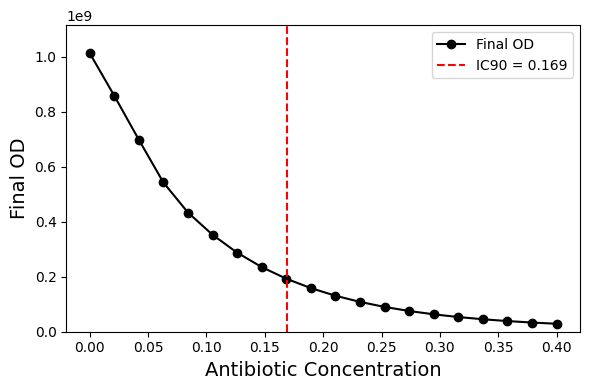

In [23]:


# Use the optimized parameters for strains_0
strains_p = [
    {
        'birth_rate': optimized_birth_rate_p,
        'initial_population': B0,
        'K': optimized_half_saturation_resource_p,
        'c': optimized_consumption_rate_p,
        'death_rate': optimized_death_rate_p,
        'A_half': optimized_A_half_p
    }
]

antibiotic_concentration_range = np.linspace(0, Amax, 20)  # Example range of concentrations from 0 to 1
final_ODs = run_dose_response(
    strains=strains_p,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentrations=antibiotic_concentration_range,
    toPlot=True
)

# Compute IC90 (90% inhibition)
IC90 = computeIC(final_ODs, IC=90, B0=B0)
print("IC90:", IC90)

# Plot dose-response curve with IC90 annotation
plot_dose_response(final_ODs, IC_concentration=IC90, IC_label="IC90")


For plasmid-free

In [24]:

target_IC90_0 = get_mean_IC90(strainID)
print("Target IC90_0:", target_IC90_0)

# Range of concentrations
antibiotic_concentration_range = np.linspace(0, Amax, 50)

# Define bounds for each parameter (modify as necessary)
bounds = [(0.001, 10), (0.001, 10)]  # Example bounds for death_rate and A_half
# Objective function remains the same as in your current setup
result_0 = differential_evolution(
    objective,
    bounds=bounds,
    args=(target_IC90_0, strains_0, initial_resource, simulation_time, antibiotic_concentration_range),
    tol=1e4,  # Can adjust as necessary
    strategy='best1bin',
    popsize=20
)

# Extract optimized parameters
optimized_death_rate_0, optimized_A_half_0 = result_0.x

optimized_death_rate_0=5
optimized_A_half_0=10

print("Optimized death_rate_0:", optimized_death_rate_0)
print("Optimized A_half_0:", optimized_A_half_0)

# Use the optimized parameters for strains_0
strains_0 = [
    {
        'birth_rate': optimized_birth_rate_0,
        'initial_population': B0,
        'K': optimized_half_saturation_resource_0,
        'c': optimized_consumption_rate_0,
        'death_rate': optimized_death_rate_0,
        'A_half': optimized_A_half_0
    }
]

dose_response_results_0 = run_dose_response(
    strains=strains_0,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentrations=antibiotic_concentration_range,
    toPlot=False
)
computed_IC90_0 = computeIC(dose_response_results_0, IC=90, B0=B0)
print("Computed IC90_0 with optimized parameters:", computed_IC90_0)


The mean IC90 for strain K209 is: 0.1
Target IC90_0: 0.1
Optimized death_rate_0: 5
Optimized A_half_0: 10
Computed IC90_0 with optimized parameters: 0.18354518674478842


In [25]:
def create_death_rates(Nmuts, Nins, max_death_rate, min_death_rate):
    """
    Creates a death_rates matrix where death rates progressively decrease from
    the top-left (0,0) corner toward the bottom-right (Nmuts-1, Nins-1) corner.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    max_death_rate (float): The death rate at position (0,0) (highest death rate).
    min_death_rate (float): The death rate at position (Nmuts-1, Nins-1) (lowest death rate).

    Returns:
    np.array: A 2D array representing death_rates with a gradient of resistance.
    """
    # Initialize the death_rates matrix
    death_rates = np.zeros((Nmuts, Nins))

    # Calculate step size for the decrease in death rate across the matrix
    for i in range(Nmuts):
        for j in range(Nins):
            # Calculate linear interpolation based on position
            rate = max_death_rate - (max_death_rate - min_death_rate) * (i + j) / (Nmuts + Nins - 2)
            death_rates[i, j] = rate

    return death_rates

# Plasmid-bearing
max_death_rate_p = optimized_death_rate_p  # Death rate for mutation level 0 (wild-type)
min_death_rate_p = optimized_death_rate_p/num_mutationsSNP  # Death rate for the highest mutation level (most resistant)
death_rates_p = create_death_rates(num_mutationsSNP, num_mutationsIS, max_death_rate_p, min_death_rate_p)
print("Death Rates_p:\n", death_rates_p)

# Plasmid-free
max_death_rate_0 = optimized_death_rate_0  # Death rate for mutation level 0 (wild-type)
min_death_rate_0 = optimized_death_rate_0/num_mutationsSNP  # Death rate for the highest mutation level (most resistant)
death_rates_0 = create_death_rates(num_mutationsSNP, num_mutationsIS, max_death_rate_0, min_death_rate_0)
print("Death Rates_0:\n", death_rates_0)

Death Rates_p:
 [[5.         4.16666667 3.33333333]
 [4.16666667 3.33333333 2.5       ]
 [3.33333333 2.5        1.66666667]]
Death Rates_0:
 [[5.         4.16666667 3.33333333]
 [4.16666667 3.33333333 2.5       ]
 [3.33333333 2.5        1.66666667]]


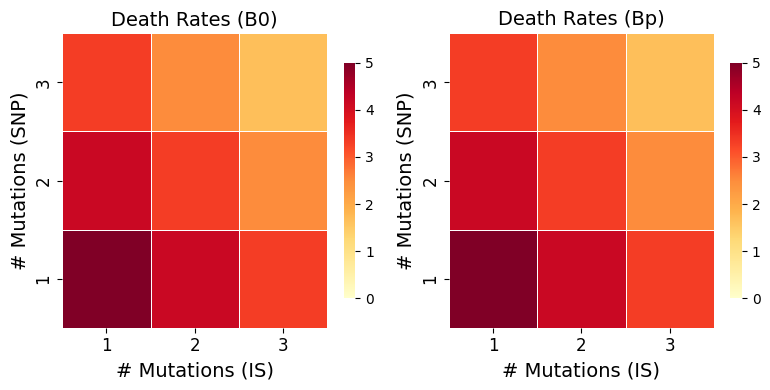

In [26]:
def plotDeathRateMatrices(death_rates_0, death_rates_p, Nmuts, Nins):
    """
    Plots the death rate matrices for plasmid-free and plasmid-bearing strains using the same color scale.

    Parameters:
    death_rates_0 (np.array): 2D array of death rates for plasmid-free strains.
    death_rates_p (np.array): 2D array of death rates for plasmid-bearing strains.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    """
    # Determine the global color scale across both matrices
    vmin = 0 #min(death_rates_0.min(), death_rates_p.min())
    vmax = max(death_rates_0.max(), death_rates_p.max())

    # Set up the matplotlib figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot death rate matrix for plasmid-free strains
    sns.heatmap(death_rates_0[::-1], ax=axes[0], cmap='YlOrRd', vmin=vmin, vmax=vmax, annot=False,
                cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white')
    axes[0].set_title("Death Rates (B0)", fontsize=14)
    axes[0].set_xlabel('# Mutations (IS)', fontsize=14)
    axes[0].set_ylabel('# Mutations (SNP)', fontsize=14)
    axes[0].set_yticks(np.arange(Nmuts) + 0.5)
    axes[0].set_yticklabels(np.arange(1, Nmuts + 1)[::-1], fontsize=12)
    axes[0].set_xticks(np.arange(Nins) + 0.5)
    axes[0].set_xticklabels(np.arange(1, Nins + 1), fontsize=12)

    # Plot death rate matrix for plasmid-bearing strains
    sns.heatmap(death_rates_p[::-1], ax=axes[1], cmap='YlOrRd', vmin=vmin, vmax=vmax, annot=False,
                cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='white')
    axes[1].set_title("Death Rates (Bp)", fontsize=14)
    axes[1].set_xlabel('# Mutations (IS)', fontsize=14)
    axes[1].set_ylabel('# Mutations (SNP)', fontsize=14)
    axes[1].set_yticks(np.arange(Nmuts) + 0.5)
    axes[1].set_yticklabels(np.arange(1, Nmuts + 1)[::-1], fontsize=12)
    axes[1].set_xticks(np.arange(Nins) + 0.5)
    axes[1].set_xticklabels(np.arange(1, Nins + 1), fontsize=12)

    plt.tight_layout()
    plt.show()

plotDeathRateMatrices(death_rates_0, death_rates_p, Nmuts=num_mutationsSNP, Nins=num_mutationsIS)


In [27]:

def create_half_saturation_antibiotic(Nmuts, Nins, half_saturation_antibiotic):
    """
    Creates a flat half_saturation_antibiotic matrix where the half-saturation antibiotics value is the same across
    all mutation and insertion levels.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    half_saturation_antibiotic (float): The constant half-saturation antibiotics value for all levels.

    Returns:
    np.array: A 2D array representing flat half_saturation_antibiotic values.
    """
    # Create the half_saturation_antibiotic matrix filled with the same value across all entries
    half_saturation_matrix = np.full((Nmuts, Nins), half_saturation_antibiotic)

    return half_saturation_matrix

# Example usage
half_saturation_antibiotic_0 = optimized_A_half_0  # Constant half-saturation for plasmid-free strains
half_saturation_antibiotic_p = optimized_A_half_p  # Constant half-saturation for plasmid-bearing strains

# Create the half_saturation_resource matrices
half_saturation_antibiotic_rates_0 = create_half_saturation_antibiotic(num_mutationsSNP, num_mutationsIS, half_saturation_antibiotic_0)
half_saturation_antibiotic_rates_p = create_half_saturation_antibiotic(num_mutationsSNP, num_mutationsIS, half_saturation_antibiotic_p)


## Mutation rates

In [28]:

# Select the worksheet by name "MutRates"
worksheet = sheet.worksheet('Data')

# Convert worksheet to a Pandas DataFrame, removing empty rows and columns
df_muts = get_as_dataframe(worksheet, evaluate_formulas=True, skiprows=0, header=0, dtype=str).dropna(how='all').dropna(axis=1, how='all')

# Display the first few rows to verify
print(df_muts.head())


# Convert necessary columns to numeric if they are not already, and handle errors gracefully
df_muts['SNP_rate'] = pd.to_numeric(df_muts['SNP_rate'], errors='coerce')
df_muts['IS1_rate'] = pd.to_numeric(df_muts['IS1_rate'], errors='coerce')

# Drop rows with NaN values in rates if any
df_muts = df_muts.dropna(subset=['SNP_rate', 'IS1_rate'])

def get_mutation_rates(strain_id):
    """
    Returns the SNP_rate and IS1_rate for a specified strain ID.

    Parameters:
    strain_id (str): The strain ID to look up.

    Returns:
    tuple: SNP_rate and IS1_rate for the specified strain ID, or (None, None) if not found.
    """
    # Filter the DataFrame for the specified strain ID
    result = df_muts[df_muts['StrainID'] == strain_id]

    # Check if strain exists and return the rates, else return None
    if not result.empty:
        snp_rate = result['SNP_rate'].values[0]
        is1_rate = result['IS1_rate'].values[0]
        print(f"The SNP_rate for strain {strain_id} is: {snp_rate}")
        print(f"The IS1_rate for strain {strain_id} is: {is1_rate}")
        return snp_rate, is1_rate
    else:
        print(f"Strain {strain_id} not found in the data.")
        return None, None

snp_rate_0, is1_rate_0 = get_mutation_rates(strainID)

snp_rate_p, is1_rate_p = get_mutation_rates("%sp"%(strainID))


  Antibiotic Strain       ODmax StrainID IC90  SNP_rate  IS1_rate      ODmax1  \
0  Colistina   K209  1298166700     K209  0.1  1.52e-08  1.69e-09  1200000000   
1  Colistina   K209  1105500000    K209p  0.1  1.21e-08  5.18e-08  1200000000   
2  Colistina   K241  1242830000     K241  0.1  3.57e-09  1.25e-08  1200000000   
3  Colistina   K241  1348500000    K241p  0.1  5.29e-09  8.82e-09  1200000000   
4  Colistina   K037  1292000000     K037  0.1  1.12e-08         0  1200000000   

  IC901    ODmax1.1 IC901.1              SNP_rate1               IS1_rate1  \
0  0.11  1200000000     0.1             1.1954e-07               3.554e-08   
1  0.12  1200000000     0.1  7.545999999999999e-08  1.6651999999999998e-07   
2  0.11  1200000000     0.1             1.1954e-07               3.554e-08   
3  0.12  1200000000     0.1  7.545999999999999e-08  1.6651999999999998e-07   
4  0.11  1200000000     0.1             1.1954e-07               3.554e-08   

  Unnamed: 15           SNP_rate_mean IS1_ra

In [29]:

# Function to create the mu_list with linearly increasing mutation rates based on transpositions
def create_mu_list_linear(Nmuts, Nins, base_rate, max_mu):
    """
    Creates a mu_list with values increasing linearly with the number of transpositions.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    base_rate (float): Minimum mutation rate when transpositions are 0.
    max_mu (float): Maximum mutation rate achievable.

    Returns:
    np.array: A 2D array representing mu_list.
    """
    # Calculate the slope for linear increase
    slope = (max_mu - base_rate) / (Nins - 1) if Nins > 1 else 0

    # Calculate mutation rates based on the linear formula
    transpositions = np.arange(Nins)
    mu_values = base_rate + slope * transpositions

    # Create the mu_list matrix
    mu_list = np.tile(mu_values, (Nmuts, 1))

    return mu_list


# Generate the mutation rates matrix (p)
base_rate_p = snp_rate_p      # Base mutation rate
max_mu_p = snp_rate_p #snp_rate_p * (num_mutationsSNP)  # Maximum mutation rate
mu_list_p = create_mu_list_linear(num_mutationsSNP, num_mutationsIS, base_rate_p, max_mu_p)
print(mu_list_p)

# Generate the mutation rates matrix (0)
base_rate_0 = snp_rate_0      # Base mutation rate
max_mu_0 = snp_rate_0 #snp_rate_0 * (num_mutationsSNP)  # Maximum mutation rate
mu_list_0 = create_mu_list_linear(num_mutationsSNP, num_mutationsIS, base_rate_0, max_mu_0)
print(mu_list_0)

[[1.21e-08 1.21e-08 1.21e-08]
 [1.21e-08 1.21e-08 1.21e-08]
 [1.21e-08 1.21e-08 1.21e-08]]
[[1.52e-08 1.52e-08 1.52e-08]
 [1.52e-08 1.52e-08 1.52e-08]
 [1.52e-08 1.52e-08 1.52e-08]]


## Parameterize transposition rates

In [30]:


def create_flat_tau_list(Nmuts, Nins, base_rate):
    """
    Creates a flat tau_list with a constant transposition rate across all levels.

    Parameters:
    Nmuts (int): Number of mutation levels (rows).
    Nins (int): Number of transposition levels (columns).
    base_rate (float): Constant transposition rate for all elements in the matrix.

    Returns:
    np.array: A 2D array representing a flat tau_list.
    """
    # Create the tau_list matrix filled with base_rate
    tau_list = np.full((Nmuts, Nins), base_rate)

    return tau_list


tau_list_p = create_flat_tau_list(num_mutationsSNP, num_mutationsIS, is1_rate_p)
print("Tau List:\n", tau_list_p)


tau_list_0 = create_flat_tau_list(num_mutationsSNP, num_mutationsIS, is1_rate_0)
print("Tau List:\n", tau_list_0)


Tau List:
 [[5.18e-08 5.18e-08 5.18e-08]
 [5.18e-08 5.18e-08 5.18e-08]
 [5.18e-08 5.18e-08 5.18e-08]]
Tau List:
 [[1.69e-09 1.69e-09 1.69e-09]
 [1.69e-09 1.69e-09 1.69e-09]
 [1.69e-09 1.69e-09 1.69e-09]]


In [31]:
# Generate data_IS dictionary from df
data_IS = {
    'strainID': df['StrainID'].str.replace('p', '', regex=False).tolist(),  # Remove 'p' for species name
    'nIS1_genome': [1 if not sid.endswith('p') else 3 for sid in df['StrainID']],  # Assign 1 or 3 based on 'p'
    'IS1_rate': df['IS1_rate'].astype(float).tolist()  # Convert IS1_rate to float
}

# Display the generated dictionary
print(data_IS)

# Filter the dataframe for the target strain
filtered_df = df[df['StrainID'].str.replace('p', '', regex=False) == strainID]

# Generate the filtered dictionary
filtered_data_IS = {
    'strainID': filtered_df['StrainID'].str.replace('p', '', regex=False).tolist(),
    'nIS1_genome': [1 if not sid.endswith('p') else 3 for sid in filtered_df['StrainID']],
    'IS1_rate': filtered_df['IS1_rate'].astype(float).tolist()
}

# Display the filtered dictionary
print(filtered_data_IS)


{'strainID': ['K209', 'K209', 'K241', 'K241', 'K037', 'K037', 'K168', 'K168', 'K253', 'K253'], 'nIS1_genome': [1, 3, 1, 3, 1, 3, 1, 3, 1, 3], 'IS1_rate': [1.69e-09, 5.18e-08, 1.25e-08, 8.82e-09, 0.0, 1.6e-09, 0.0, 1.21e-08, 3.58e-09, 8.94e-09]}
{'strainID': ['K209', 'K209'], 'nIS1_genome': [1, 3], 'IS1_rate': [1.69e-09, 5.18e-08]}


In [32]:


def create_tau_lists_from_fit(x_fit, y_fit, Nmuts, Nins, shift_amount):
    """
    Creates tau_list_0 and tau_list_p by interpolating fitted exponential decay data with a shift.

    Parameters:
    x_fit (np.array): Fitted x values (nIS1 per genome) from the exponential fit.
    y_fit (np.array): Fitted y values (IS1 rate) from the exponential fit.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    shift_amount (int): Number of columns to shift for the plasmid-bearing (_p) version.

    Returns:
    tuple: Two 2D arrays representing tau_list_0 and tau_list_p.
    """
    # Define the interpolation function based on x_fit and y_fit
    interpolation_function = interp1d(x_fit, y_fit, fill_value="extrapolate")

    # Generate insertion levels from 0 to Nins - 1 + shift_amount
    insertions = np.arange(Nins + shift_amount)

    # Interpolate tau values for each insertion level
    tau_values = interpolation_function(insertions)

    # Create the tau_list matrix by repeating tau_values for each mutation level
    full_tau_list = np.tile(tau_values, (Nmuts, 1))

    # For tau_list_0: Take the first Nins columns
    tau_list_0 = full_tau_list[:, :Nins]

    # For tau_list_p: Take the next Nins columns, starting from column `shift_amount`
    tau_list_p = full_tau_list[:, shift_amount:shift_amount + Nins]

    return tau_list_0, tau_list_p

#shift_amount = 2

# Generate tau_list_0 and tau_list_p using the fitted curve data with the specified shift
#tau_list_0, tau_list_p = create_tau_lists_from_fit(x_fit, y_fit, num_mutationsSNP, num_mutationsIS, shift_amount)

print("Tau List_0:\n", tau_list_0)
print("Tau List_p:\n", tau_list_p)


Tau List_0:
 [[1.69e-09 1.69e-09 1.69e-09]
 [1.69e-09 1.69e-09 1.69e-09]
 [1.69e-09 1.69e-09 1.69e-09]]
Tau List_p:
 [[5.18e-08 5.18e-08 5.18e-08]
 [5.18e-08 5.18e-08 5.18e-08]
 [5.18e-08 5.18e-08 5.18e-08]]


## Export parameters

In [33]:


# Plasmid-free strains
strains_0 = []
for i in range(num_mutationsSNP):
    for j in range(num_mutationsIS):
        strain = {
            'strainID': strainID,
            'segregation_rate': segregation_rate,
            #'conjugation_rate': conjugation_rate,
            'birth_rate': birth_rates_0[i, j],
            'consumption_rate': consumption_rates_0[i, j],
            'half_saturation_resource': half_saturation_resource_rates_0[i, j],
            'mutation_rate': mu_list_0[i, j] ,
            'transposition_rate': tau_list_0[i,j],
            'death_rate': death_rates_0[i, j],
            'half_saturation_antibiotic': half_saturation_antibiotic_rates_0[i, j],  # Distinct value for resource limitation per transposition level
        }
        strains_0.append(strain)

# Plasmid-bearing strains
strains_p = []
for i in range(num_mutationsSNP):
    for j in range(num_mutationsIS):
        strain = {
            'strainID': strainID,
            'segregation_rate': segregation_rate,
            #'conjugation_rate': conjugation_rate,
            'birth_rate': birth_rates_p[i, j],
            'consumption_rate': consumption_rates_p[i, j],
            'half_saturation_resource': half_saturation_resource_rates_p[i, j],
            'mutation_rate': mu_list_p[i, j] ,
            'transposition_rate': tau_list_p[i,j],
            'death_rate': death_rates_p[i, j],
            'half_saturation_antibiotic':  half_saturation_antibiotic_rates_p[i, j]  # Distinct value for antibiotic susceptibility per mutation level
        }
        strains_p.append(strain)
print(strains_p)

[{'strainID': 'K209', 'segregation_rate': 1e-07, 'birth_rate': np.float64(0.8000220386606708), 'consumption_rate': np.float64(1.0944212227721549e-09), 'half_saturation_resource': np.float64(0.5999972440473462), 'mutation_rate': np.float64(1.21e-08), 'transposition_rate': np.float64(5.18e-08), 'death_rate': np.float64(5.0), 'half_saturation_antibiotic': np.int64(10)}, {'strainID': 'K209', 'segregation_rate': 1e-07, 'birth_rate': np.float64(0.7900217631774125), 'consumption_rate': np.float64(1.0944212227721549e-09), 'half_saturation_resource': np.float64(0.5999972440473462), 'mutation_rate': np.float64(1.21e-08), 'transposition_rate': np.float64(5.18e-08), 'death_rate': np.float64(4.166666666666667), 'half_saturation_antibiotic': np.int64(10)}, {'strainID': 'K209', 'segregation_rate': 1e-07, 'birth_rate': np.float64(0.780021487694154), 'consumption_rate': np.float64(1.0944212227721549e-09), 'half_saturation_resource': np.float64(0.5999972440473462), 'mutation_rate': np.float64(1.21e-08),

In [34]:
exportPKL=False
if exportPKL:

    # Save plasmid-free strains (strains_0) to a .pkl file
    file_0='params_%s_0.pkl'%strainID
    with open('%s%s'%(pathPARAMS, file_0), 'wb') as f:
        pickle.dump(strains_0, f)
    print("Plasmid-free parameters for strain %s saved successfully in: \n%s%s\n"%(strainID, pathPARAMS, file_0))

    # Save plasmid-bearing strains (strains_p) to a .pkl file
    file_p='params_%s_p.pkl'%strainID
    with open('%s%s'%(pathPARAMS, file_p), 'wb') as f:
        pickle.dump(strains_p, f)
    print("Plasmid-bearing parameters for strain %s saved successfully in: \n%s%s\n"%(strainID, pathPARAMS, file_p))

